# Activity Investigation

This should be helpful when I just want to look closely at the results of a particular activity stream

In [1]:
from strava.data.cache import Cache
from strava.data.strava_requests import *
from strava.plotting.strava_annual_plots import *
from strava.plotting.strava_stream_plots import *
from generate_plots import get_clean_activities, get_clean_stream
from strava.data.cache import Cache

import aiohttp
import asyncio
import copy
from datetime import date
import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
import requests
import os
import pandas as pd
from pandas_profiling import ProfileReport
from plotnine import ggplot, aes
import plotnine as gg
import time
from typing import List
import urllib3
import PIL
from PIL import Image
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
gg.options.figure_size = (11, 8.5)
pt.dark()

pd.set_option('display.max_columns', 500)

%load_ext autoreload
%autoreload 2

In [2]:
# Create a cache
cache = Cache()

In [6]:
# Get a list of activities
activities = get_clean_activities()
activities.head()

Existing access token is valid.
Beginning request of activities...
-> Received page 1 with 200 activities.
-> Received page 2 with 200 activities.
-> Received page 3 with 195 activities.
-> Received page 4 with 0 activities.
...retrieved total of 595 activities.


,id,name,distance,moving_time,elapsed_time,total_elevation_gain,elev_high,elev_low,sport_type,start_date_local,timezone,start_latlng,end_latlng,achievement_count,map.id,workout_type,average_speed,max_speed,average_heartrate,max_heartrate,map.summary_polyline,year,date_year_agnostic
14,11214280814,Collision special,20172.3,0 days 00:52:49,34 days 03:57:33,235.7,101.1,3.5,Ride,2024-03-15 16:32:46,(GMT-08:00) America/Vancouver,"[49.05513323843479, -122.77457839809358]","[49.05696954578161, -122.85631871782243]",0,a11214280814,10.0,22.9176,57.0528,176.5,193.0,caljH|tjlVXfANR\Ed@g@D@P^ZpBLj@^dAL`Bb@bA@l@JP...,2024,1970-03-15 16:32:46
26,10818058984,Pre-Season Testing,11187.5,0 days 00:29:14,0 days 00:30:53,109.6,103.1,52.1,Ride,2024-02-22 16:44:42,(GMT-08:00) America/Vancouver,"[49.055141704156995, -122.7743905596435]","[49.055102141574025, -122.77465936727822]",2,a10818058984,10.0,22.9608,41.3640,170.0,188.0,{aljHjtjlV\nANXJHFBHEJ_@`@a@D?PV?`ADh@THVzAF`@...,2024,1970-02-22 16:44:42
90,10045628823,Morning Ride,52342.9,0 days 02:04:14,0 days 02:10:43,636.4,101.0,0.0,Ride,2023-10-15 10:11:28,(GMT-08:00) America/Vancouver,"[49.05280818231404, -122.78578190132976]","[49.05504908412695, -122.77461444027722]",8,a10045628823,NaN,25.2792,60.7608,167.6,186.0,sskjHd_mlVThUW|GLjAQJbA~@Q^JTzOyQrCwBr^AtDmAdE...,2023,1970-10-15 10:11:28
91,10033794476,Afternoon Ride,28362.3,0 days 01:07:07,0 days 01:09:07,351.6,101.0,0.4,Ride,2023-10-13 16:35:18,(GMT-08:00) America/Vancouver,"[49.05503843910992, -122.77440589852631]","[49.05511471442878, -122.7746445313096]",3,a10033794476,NaN,25.3548,60.1128,165.4,187.0,oaljHbtjlVXlAZn@XKDg@LIp@b@RtBd@l@VnAh@bEDrAb@...,2023,1970-10-13 16:35:18
92,10028527513,Afternoon Ride,20236.1,0 days 00:41:18,0 days 00:41:45,113.1,57.3,3.7,Ride,2023-10-12 17:28:50,(GMT-08:00) America/Vancouver,"[49.05520582571626, -122.77438318356872]","[49.05501153320074, -122.77470882050693]",7,a10028527513,NaN,29.3976,64.8360,171.8,185.0,sdljHtrilV@eFF}@f@mAHq@BoAr@I?DI@eBQsA|@UAo@A}...,2023,1970-10-12 17:28:50


In [5]:
# Select only specific activities
cres = activities.query('year == 2023 & distance < 28900 & distance > 28200')
cres = activities.query('year == 2025')
# cres = activities.query('year != 2023')
print(cres.shape)
cres.head(15)

(0, 23)


,id,name,distance,moving_time,elapsed_time,total_elevation_gain,elev_high,elev_low,sport_type,start_date_local,timezone,start_latlng,end_latlng,achievement_count,map.id,workout_type,average_speed,max_speed,average_heartrate,max_heartrate,map.summary_polyline,year,date_year_agnostic


/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 37'. Pick better value with 'binwidth'.


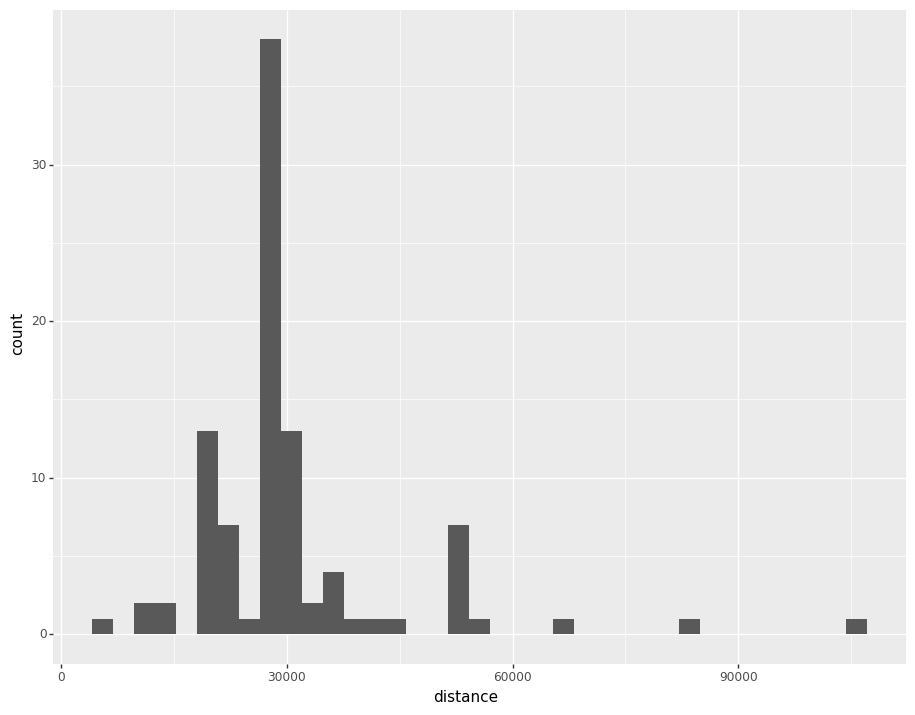

<ggplot: (867703313)>

In [14]:
# description of the distance of all of these activities
(gg.ggplot(cres, gg.aes(x='distance')) + gg.geom_histogram())

In [15]:
# Request the full streams for all of the activities
cres_act = []
for da in cres.start_date_local.apply(lambda x: x.date()):
    cres_act.append(get_clean_stream(activities, da, cache))
cres_act = pd.concat(cres_act)

Found activity 10045628823 in cache.
Found activity 10033794476 in cache.
Found activity 10028527513 in cache.
Found activity 10003148059 in cache.
Found activity 9996006537 in cache.
Found activity 9990461310 in cache.
Found activity 9985137901 in cache.
Found activity 9978987119 in cache.
Found activity 9946322578 in cache.
Found activity 9940528230 in cache.
Found activity 9911215580 in cache.
Found activity 9902256544 in cache.
Found activity 9890069161 in cache.
Found activity 9851417814 in cache.
Found activity 9831605045 in cache.
Found activity 9824564333 in cache.
Found activity 9805624701 in cache.
Found activity 9778059904 in cache.
Found activity 9765687810 in cache.
Found activity 9759475809 in cache.
Found activity 9753449004 in cache.
Found activity 9732826501 in cache.
Found activity 9726909979 in cache.
Found activity 9721132382 in cache.
Found activity 9702570543 in cache.
Found activity 9681559117 in cache.
Found activity 9662971128 in cache.
Found activity 965617966

In [16]:
cres_act.head(15)

,moving,latlng,velocity,distance,altitude,heartrate,time,id
0,False,"[49.052808, -122.785782]",0.0000,7.2,65.8,156,0,10045628823
1,True,"[49.052827, -122.785993]",0.0000,12.7,66.5,156,1,10045628823
2,True,"[49.052843, -122.786098]",0.0000,18.3,66.8,156,2,10045628823
3,True,"[49.05286, -122.786203]",19.9188,23.8,67.2,156,3,10045628823
4,True,"[49.052853, -122.786256]",18.4932,27.8,67.3,156,4,10045628823
5,True,"[49.052875, -122.786349]",19.9584,34.9,67.7,156,5,10045628823
6,True,"[49.05289, -122.786415]",19.6884,40.1,67.9,156,6,10045628823
7,True,"[49.052887, -122.786513]",20.8476,47.2,68.2,156,7,10045628823
8,True,"[49.052886, -122.786606]",21.7368,54.0,68.6,156,8,10045628823
9,True,"[49.052894, -122.7867]",23.9112,61.0,68.9,156,9,10045628823


In [17]:
# Separate the latitude and longitude into their own columns
cres_act['lat'] = cres_act.latlng.apply(lambda x: x[0])
cres_act['lng'] = cres_act.latlng.apply(lambda x: x[1])

In [18]:
# Smooth out the velocity for graphing
smoothing_window = 20
cres_act['vel_smooth'] = cres_act.groupby('id')['velocity'].transform(lambda x: x.rolling(smoothing_window, center=True).mean())
cres_act['vel_smooth'].head(20)

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10    18.62064
11    19.67400
12    20.73996
13    21.83184
14    21.95406
15    22.17060
16    22.33584
17    22.51062
18    22.63608
19    22.93920
Name: vel_smooth, dtype: float64

/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 19 rows containing missing values.


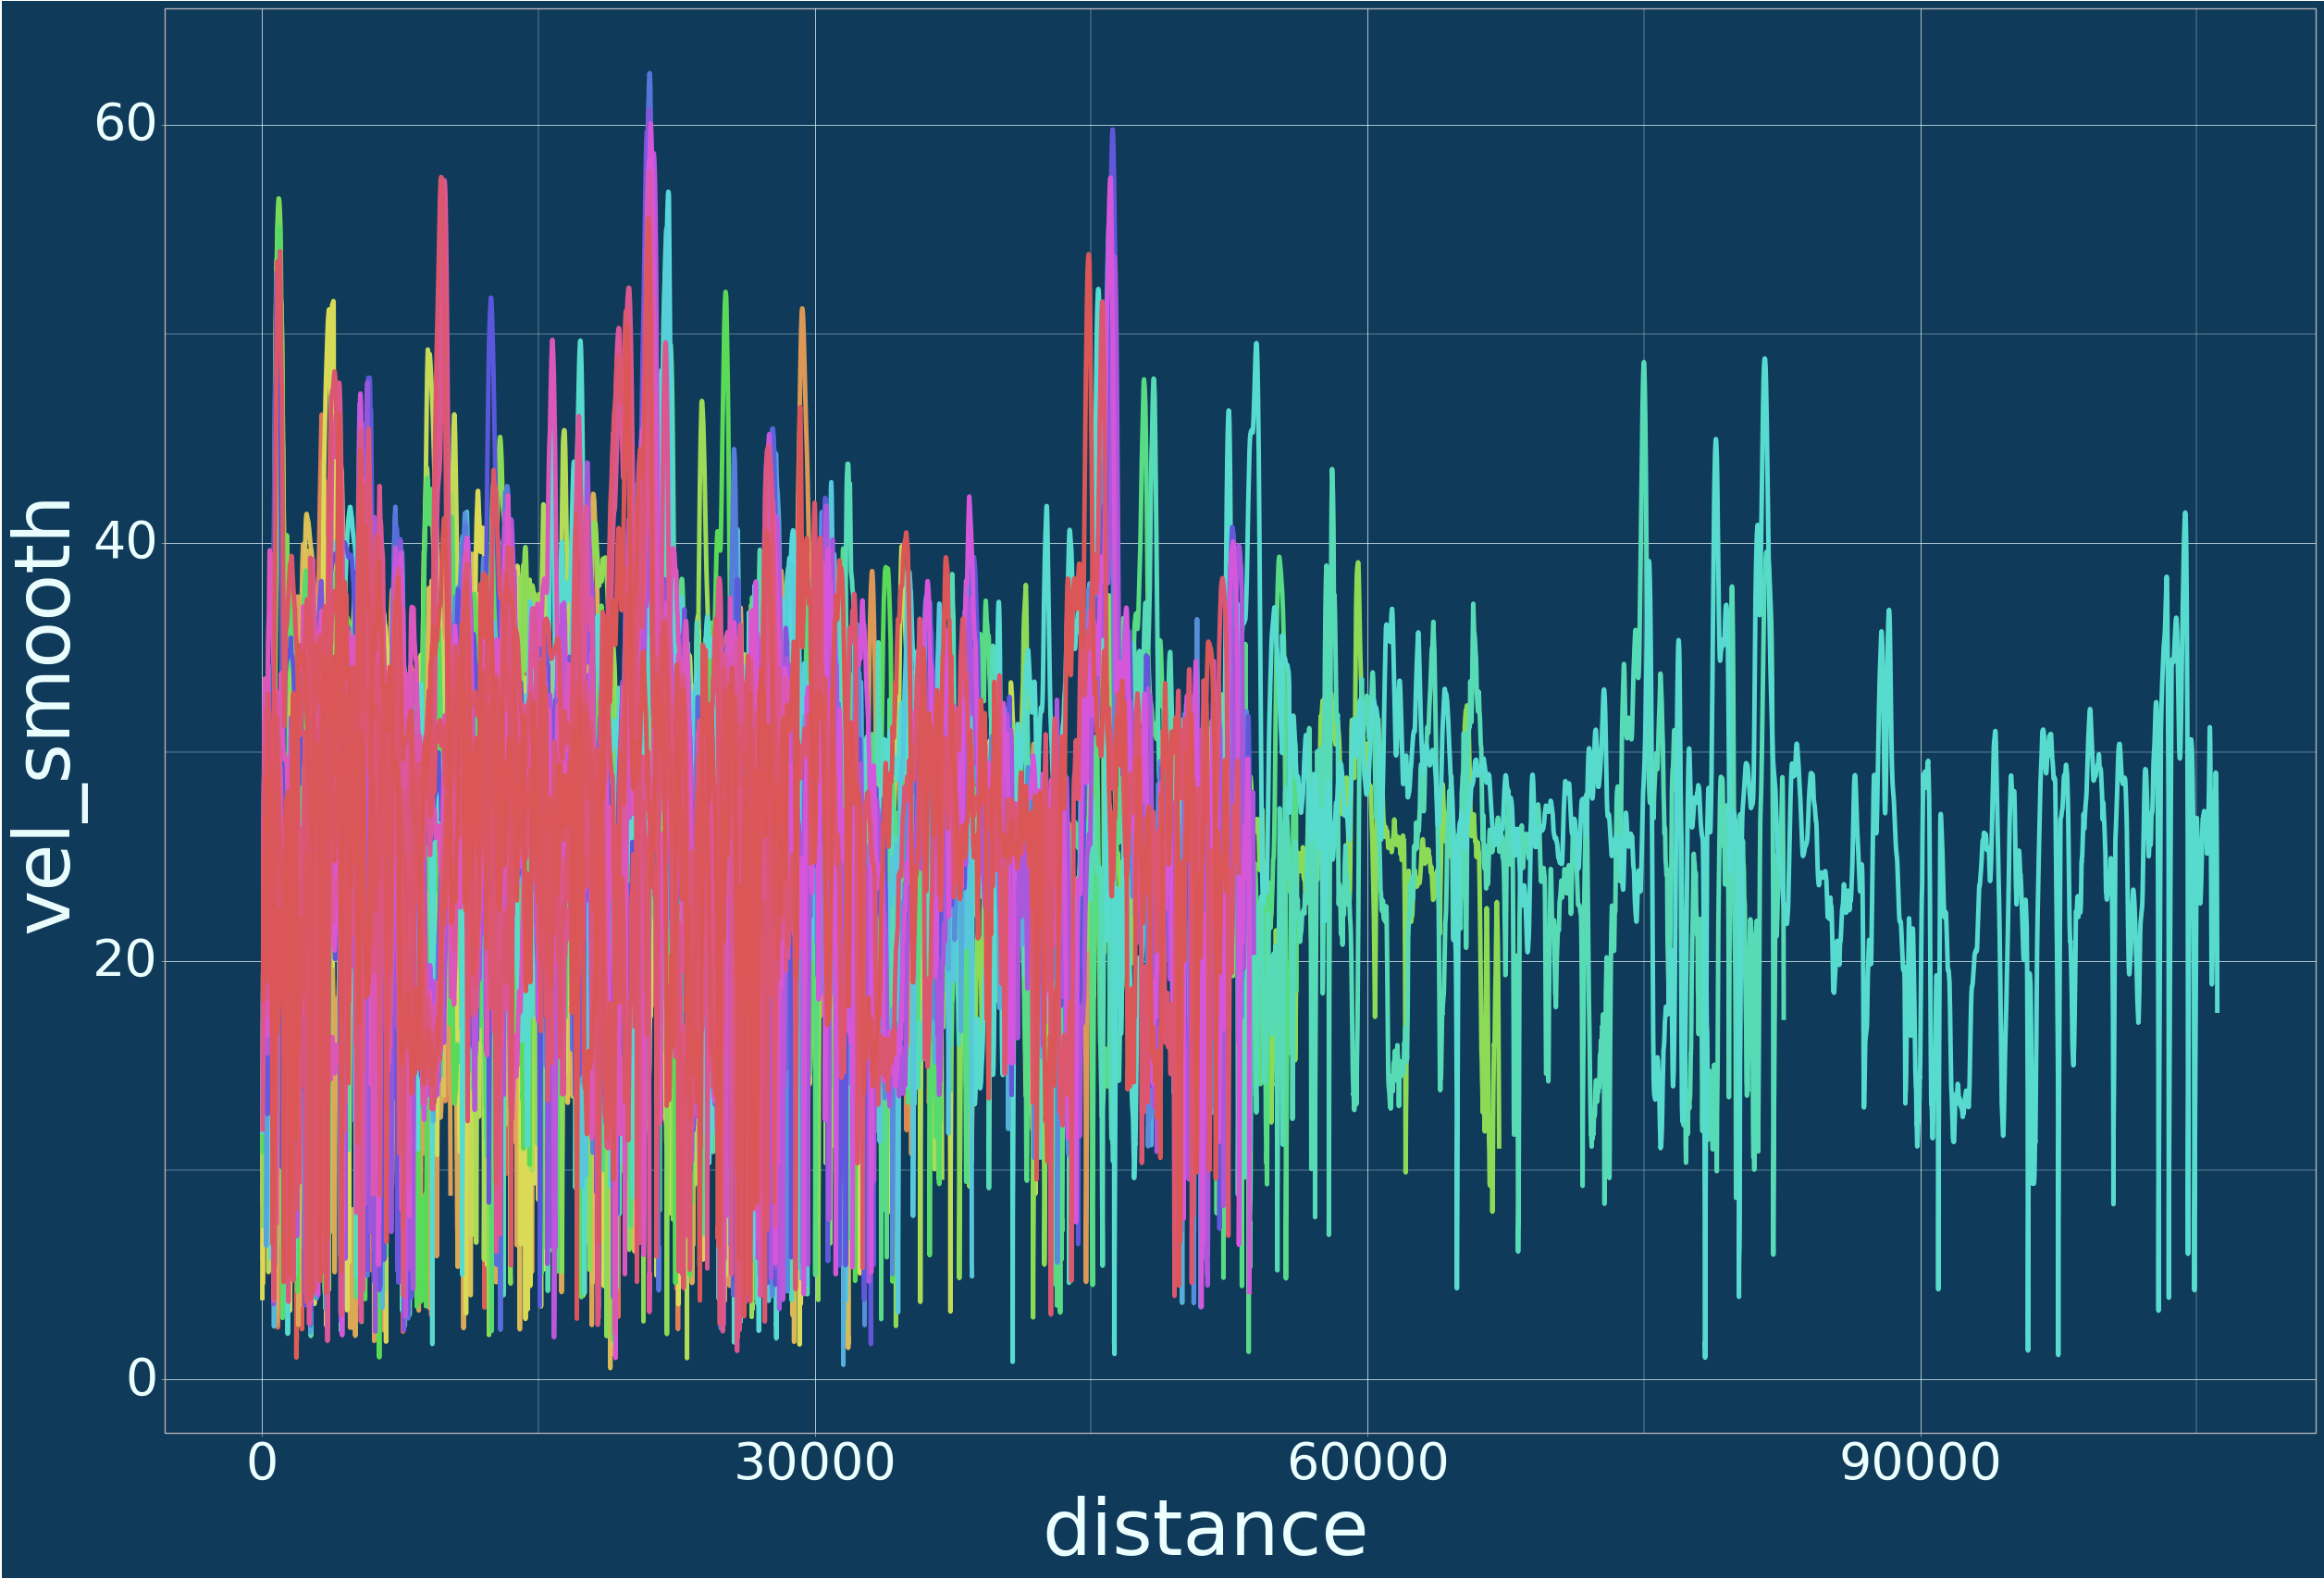

<ggplot: (857113576)>

In [19]:
# smoothed velocity over distance
pt.dark()
(gg.ggplot(cres_act, gg.aes(x='distance', y='vel_smooth', colour='factor(id)')) 
    + gg.geom_line(size=2)
    + gg.theme(figure_size=(20, 15))
    # + gg.scale_x_continuous(limits=[13000, 22000])
    + gg.scale_colour_discrete(guide=False)
    + pt.gg_theme()
    )

/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_point : Removed 27239 rows containing missing values.


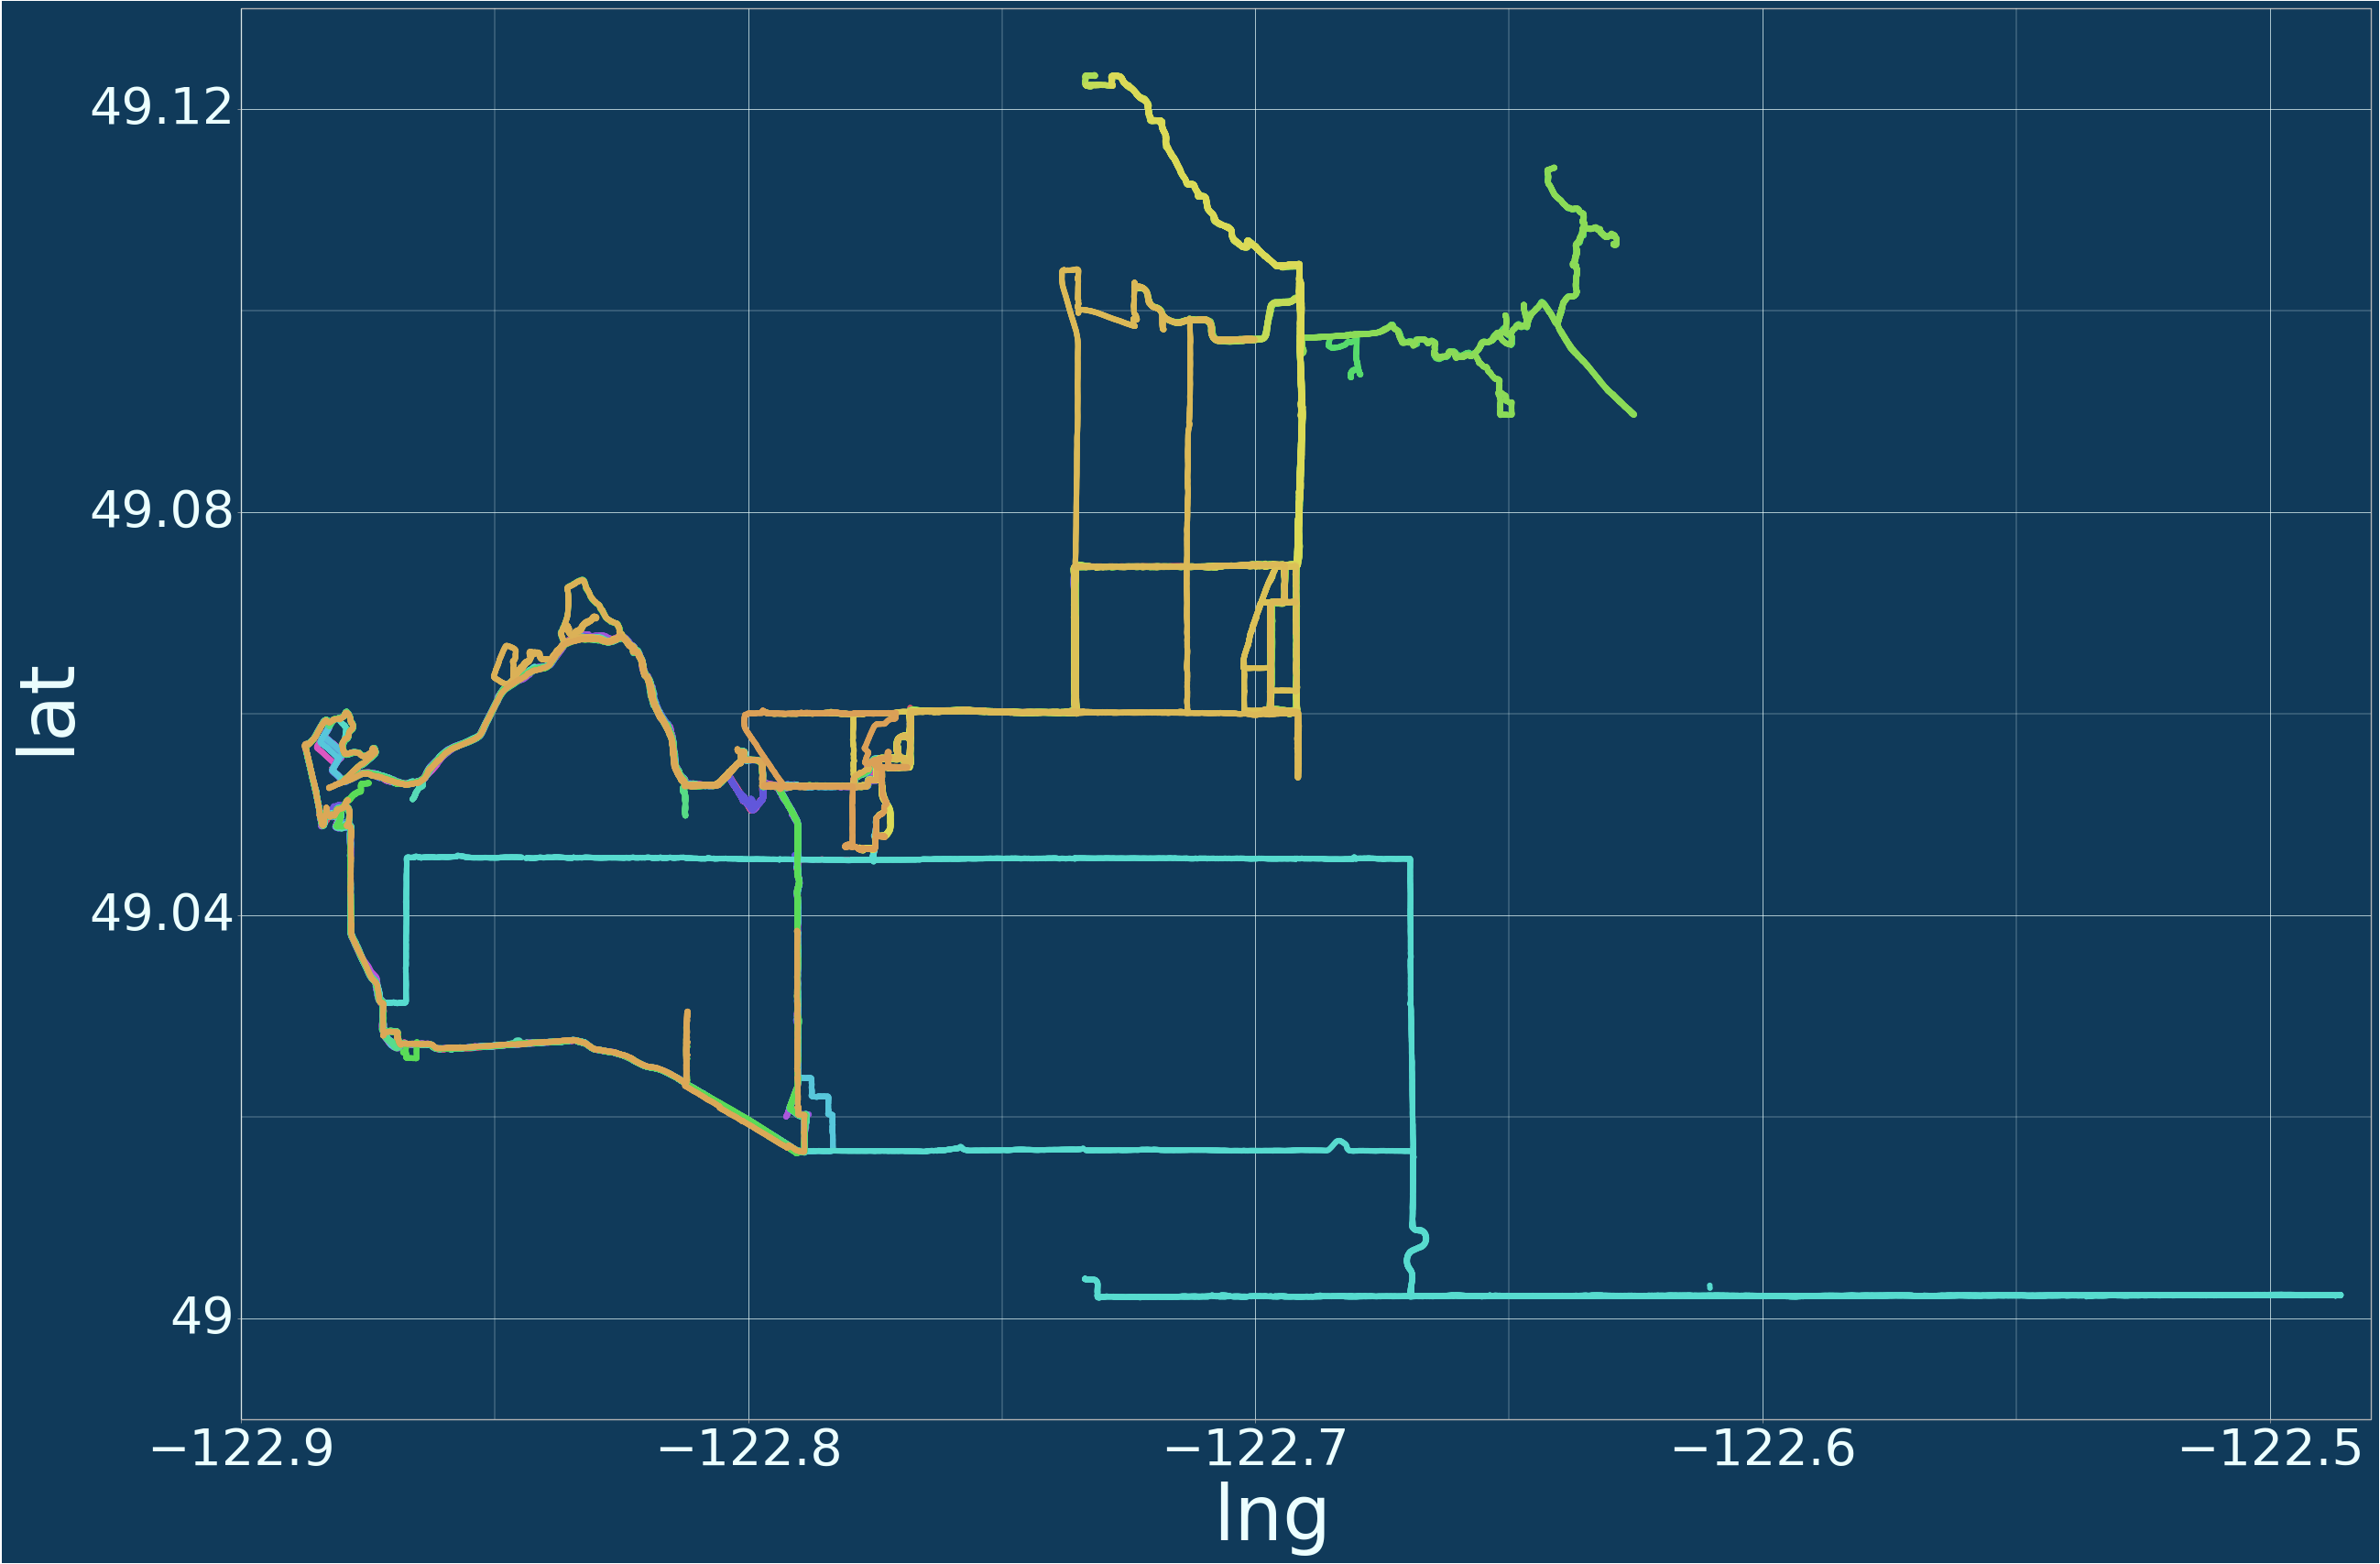

<ggplot: (829704226)>

In [20]:
# Plot of the route
# These are for crescent Beach
# xmin = 49.045
# xmax = 49.06
# ymin = -122.9
# ymax = -122.87
# Lower Mainland
ymin = 48.99
ymax = 49.13
xmin = -122.9
xmax = -122.48
# Edmonton
# ymin = 53.51
# ymax = 53.7
# xmin = -113.68
# xmax = -113.35
scale = 5
pt.dark()
(gg.ggplot(cres_act, gg.aes(x='lng', y='lat', colour='factor(id)')) 
    + gg.geom_point()
    + gg.theme(figure_size=[1 * scale, abs((ymax - ymin)/(xmax-xmin)) * scale])
    + gg.scale_x_continuous(limits=[xmin, xmax], expand=[0, 0])
    + gg.scale_y_continuous(limits=[ymin, ymax], expand=[0, 0])
    + gg.scale_colour_discrete(guide=False)
    + pt.gg_theme()
    )

/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_point : Removed 27239 rows containing missing values.


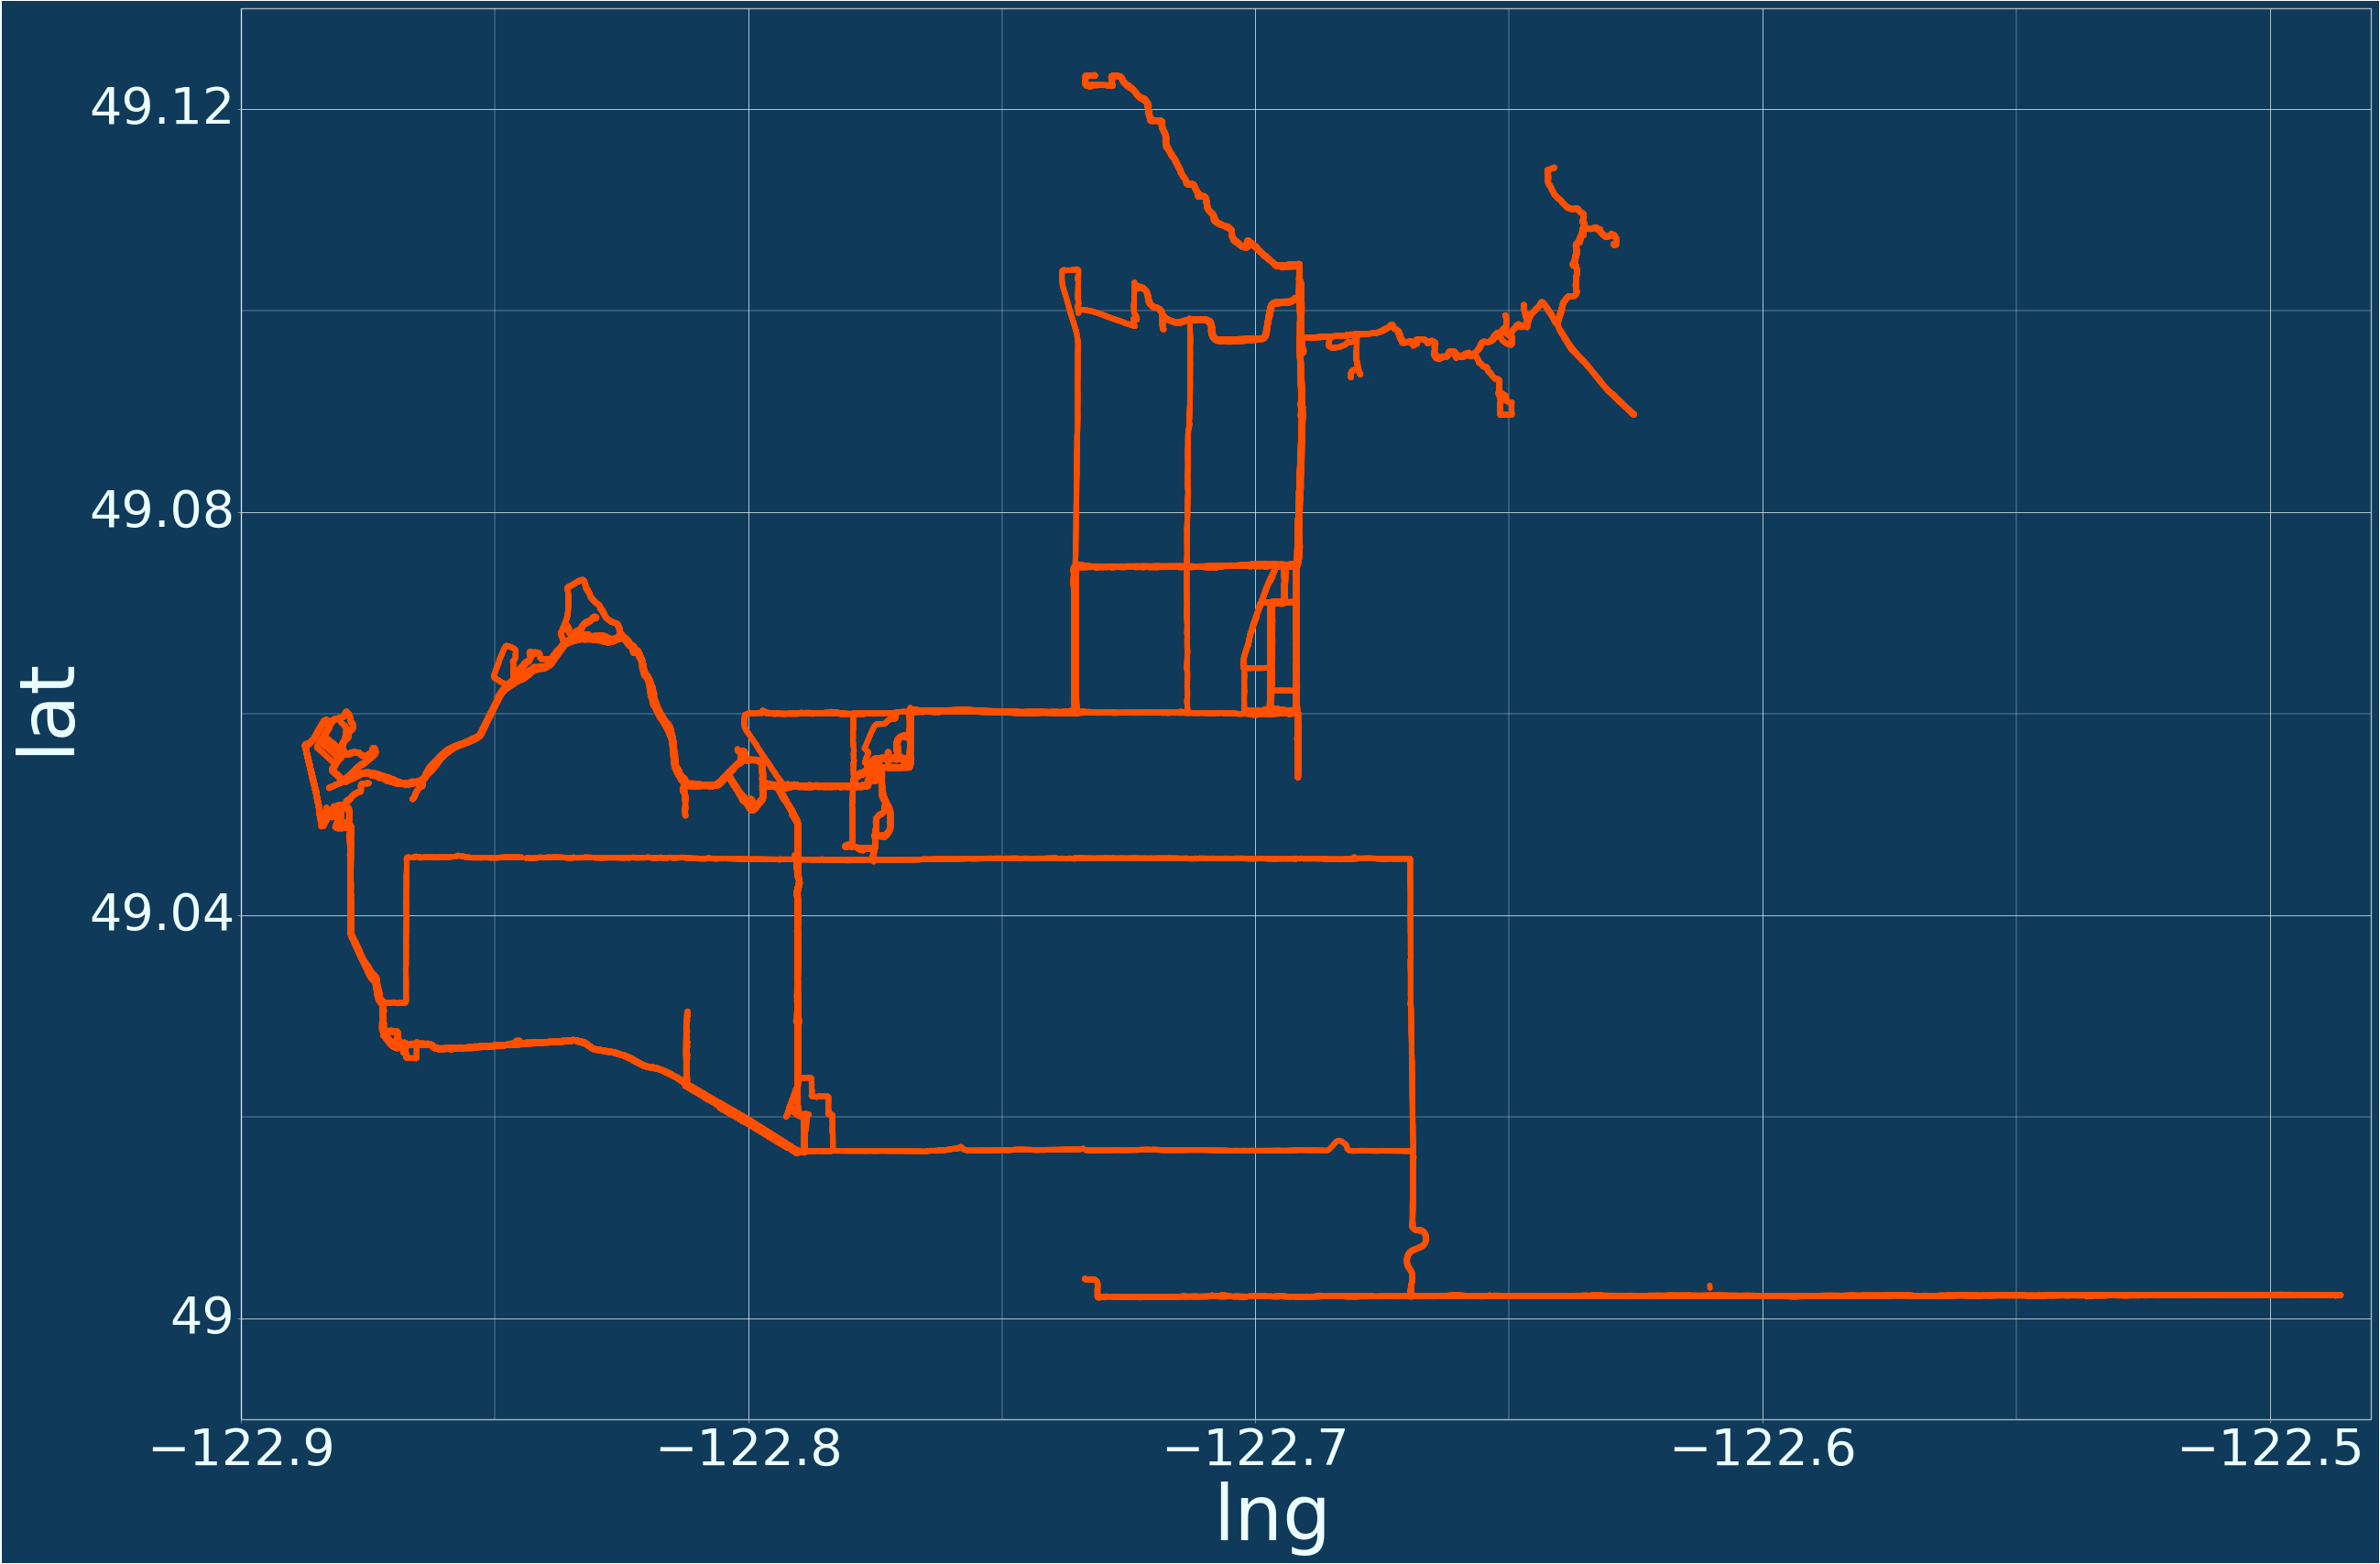

<ggplot: (857131837)>

In [21]:
# Plot of the route
# These are for crescent Beach
# xmin = 49.045
# xmax = 49.06
# ymin = -122.9
# ymax = -122.87
# Regular Ride
ymin = 48.99
ymax = 49.13
xmin = -122.9
xmax = -122.48
scale = 5
pt.dark()
(gg.ggplot(cres_act, gg.aes(x='lng', y='lat', group='id')) 
    + gg.geom_point(colour='#ff4f00')
    + gg.theme(figure_size=[1 * scale, abs((ymax - ymin)/(xmax-xmin)) * scale])
    + gg.scale_x_continuous(limits=[xmin, xmax], expand=[0, 0])
    + gg.scale_y_continuous(limits=[ymin, ymax], expand=[0, 0])
    # + gg.scale_colour_discrete(guide=False)
    + pt.gg_theme()
    )